# Práctica 1 - Visión Artificial

**Autores:** José María García Ortiz, Levi Malest Villareal y Ana Gil Molina

## Importación de las librerías necesarias

In [1]:
# Cargamos aquí las librerías que vamos a utilizar:

import math
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.transform as transform
import skimage.exposure as exposure
import skimage.filters as filters
import skimage.color as color
import skimage.morphology as morphology
import skimage.restoration as restoration
import cv2
import matplotlib

from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from scipy import ndimage as ndi
from ipywidgets import FloatSlider, interact, fixed

# from google.colab.patches import cv2_imshow
from skimage import measure

## Definición de funciones auxiliares
Definimos algunas funciones auxiliares reutilizando el código de las notebooks de clase

In [2]:
def imshow_all(*images, titles=None, cmaps=None):
    # Convertimos a imágenes de tipo float skimage (https://scikit-image.org/docs/stable/user_guide/numpy_images.html):
    images = [skimage.img_as_float(img) for img in images]
    if titles is None:
        titles = [''] * len(images)
    # Escalamos la visualización de imágenes al rango entre el máximo y el mínimo
    # valor de píxel de *todas* las imágenes a mostrar:
    vmin, vmax = min(map(np.min, images)), max(map(np.max, images))
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(5.0*len(images), 5.0))
    if cmaps is None:
        cmaps = len(images)*["gray"]
    for ax, img, label, cmap in zip(axes.ravel(), images, titles, cmaps):
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(label)


def plot_gauss_filter(image, sigma):
  impulse = np.zeros((9, 9), dtype=float)
  impulse[4, 4] = 1.0
  gauss_filter = filters.gaussian(impulse, sigma=sigma)
  img_gauss_filtered = filters.gaussian(image, sigma=sigma)
  fig, axs = plt.subplots(1, 3, figsize = (15.,5.))
  axs[0].imshow(image, cmap="gray")
  axs[0].set_title("Original")
  axs[1].imshow(img_gauss_filtered, cmap="gray")
  axs[1].set_title(f"Resultado de filtro gaussiano")
  axs[2].imshow(gauss_filter, cmap="gray")
  axs[2].set_title("Filtro utilizado")
  plt.show();

  interact(plot_gauss_filter,
         image=fixed(img_pixelated),
         sigma=FloatSlider(value=1.0,min=1.0,max=2.0, orientation='horizontal', continuous_update=False));

## Código para leer ficheros desde Drive

In [3]:
from google.colab import drive
import os
import shutil
import gdown
import zipfile


# IDs de los archivos compartidos (reemplaza con los IDs de tus archivos .zip)
file_ids = ['1Cen9C8JUsS9zEaM9r0abyyC8cfu8g1YH', '1U3l67Tw6-KsrPI9AQ9NullORE9U1G7UQ']  # Cambia estos IDs por los de tus archivos

    #https://drive.google.com/file/d/1Cen9C8JUsS9zEaM9r0abyyC8cfu8g1YH/view?usp=sharing

# Nombres locales para los archivos descargados y descomprimidos
download_paths = ['/ComputerVisionFiles.zip', '/stereopairs.zip']
extract_paths = ['', '']

# Descargar y descomprimir cada archivo
for file_id, download_path, extract_path in zip(file_ids, download_paths, extract_paths):
    # Descargar archivo
    gdown.download(f'https://drive.google.com/uc?id={file_id}', download_path, quiet=False)

    # Descomprimir el archivo ZIP
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f"Archivos descomprimidos en '{extract_path}'")

Downloading...
From (original): https://drive.google.com/uc?id=1Cen9C8JUsS9zEaM9r0abyyC8cfu8g1YH
From (redirected): https://drive.google.com/uc?id=1Cen9C8JUsS9zEaM9r0abyyC8cfu8g1YH&confirm=t&uuid=e7b1d451-ded8-4366-9879-22f80663f800
To: /ComputerVisionFiles.zip
100%|██████████| 29.8M/29.8M [00:01<00:00, 26.0MB/s]


Archivos descomprimidos en ''


Downloading...
From: https://drive.google.com/uc?id=1U3l67Tw6-KsrPI9AQ9NullORE9U1G7UQ
To: /stereopairs.zip
100%|██████████| 14.5M/14.5M [00:00<00:00, 48.8MB/s]


Archivos descomprimidos en ''


## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio RC1A (0.4 pts)</strong></div>

* Obtener los respectivos mapas de profundidad para algunas de las imágenes de *stereopairs*.

* Para ello, extraer de cada imagen global las dos imágenes izquierda y derecha del par estéreo (usando algún tipo de umbralizado seguido del cálculo de las dos componentes conexas rectangulares
que engloban a cada imagen por separado y la clase cv2.StereoBM de OpenCV)

### **Planteamiento del ejercicio**

- Primero, leemos el archivo .jpg que contiene la imagen original (dos mitades a color) y lo siguiente es convertir la imagen RGB a escala de grises y utilizar umbralizado seguido del cálculo de las componentes conexas de la imagen.

- Una vez que alamcenamos las dos componentes conexas, calculamos sus respectivas bounding boxes y aprovechamos sus coordenadas para recortar el trozo de imagen que queda fuera de la *region of interest*. Tras ello habremos completado la primera parte del ejercicio y ya tendremos separado el par estéreo de la imagen originalen dos imágenes en escala de gris.

- Para finalizar emplearemos la clase cv2.StereoBM sobre el par estéreo para elaborar el mapa de profundidad.


Dominio: 1050x1308
Rango: uint8 (min:0, max:255    |    float64 (min:0.0, max:1.0)


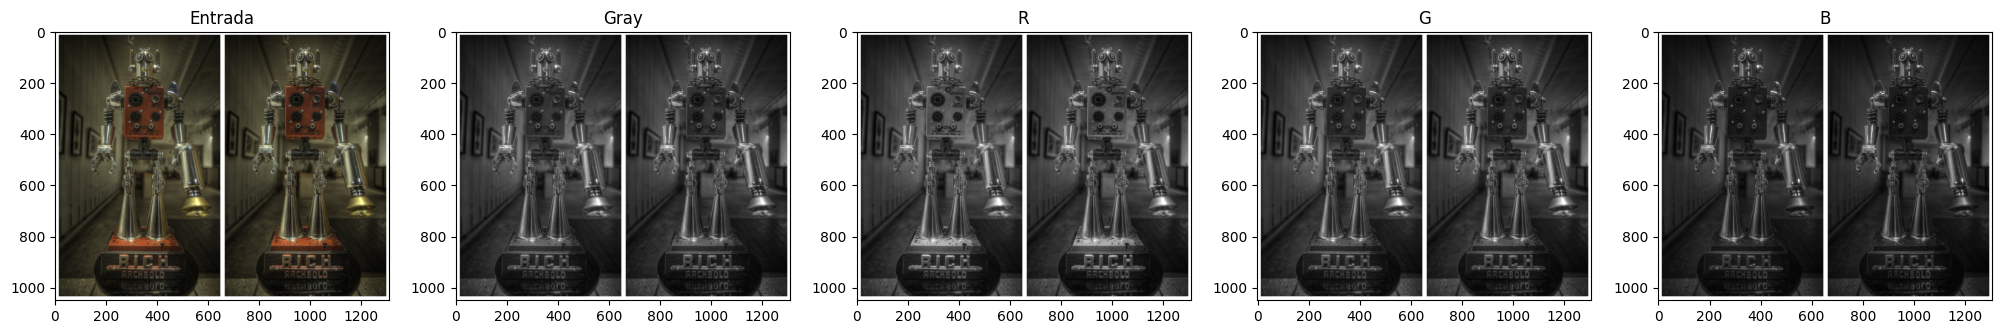

In [4]:
# Leemos la imagen, la transformamos a escala de grises y visualizamos:

img_bgr = cv2.imread('stereopairs/robot.jpg')


# OJO: La librería OpenCV opera por defecto con BGR en lugar de RGB, así que necesitamos intercambiar esos dos canales.
b,g,r = cv2.split(img_bgr)           # guardamos b, g, r
img = cv2.merge([r,g,b])             # cambiamos a r, g, b

imgGray = color.rgb2gray(img)     # Convertimos el RGB en escala de grises


# Hacemos los plots:
imgR, imgG, imgB = tuple([img[:,:,i] for i in range(3)])
imshow_all(img, imgGray, imgR, imgG, imgB, titles=["Entrada","Gray","R","G","B"])
print(f"Dominio: {imgGray.shape[0]}x{imgGray.shape[1]}")
print(f"Rango: {imgR.dtype} (min:{imgR.min()}, max:{imgR.max()}    |    {imgGray.dtype} (min:{imgGray.min()}, max:{imgGray.max()})")

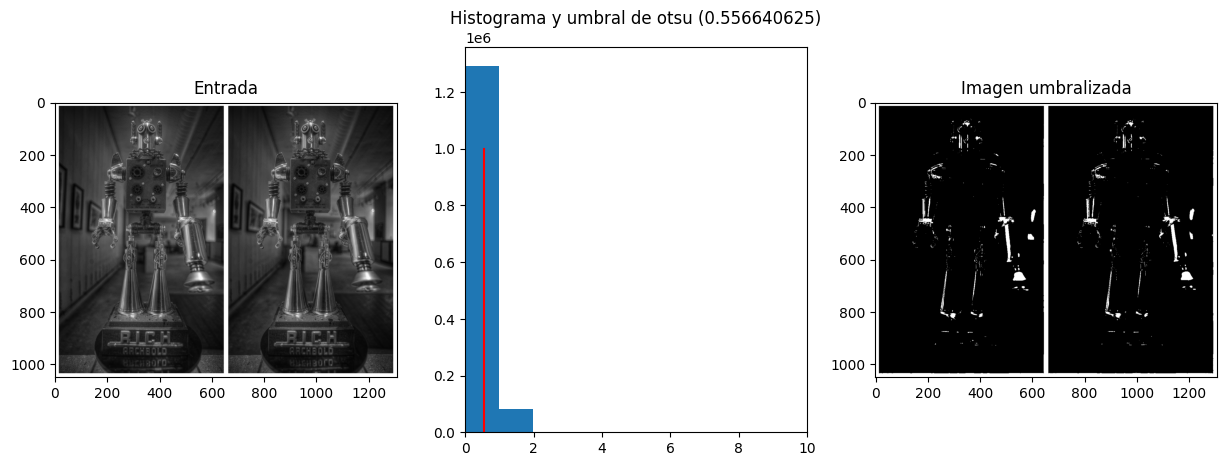

In [5]:
# Umbralizamos la imagen en escala de gris con el umbral de Otsu y mostramos los resultados con unos plots:
thr_otsu = filters.threshold_otsu(imgGray)          # Umbralizamos la imagen primeramente con umbral de Otsu
fig, axs = plt.subplots(1, 3, figsize = (15.,5.))
axs[0].imshow(imgGray, cmap="gray")
axs[0].set_title("Entrada")
axs[1].hist(imgGray.ravel(), bins=256, range=[0, 255])
axs[1].set_xlim(0, 10);                                             # Era necesario restringir el dominio del eje X en este plot para apreciar el umbral
axs[1].set_title(f"Histograma y umbral de otsu ({thr_otsu})")       # Plot del umbral de Otsu junto con el histograma de la imagen umbralizada
axs[1].plot([thr_otsu, thr_otsu], [0, 1e6], 'r-')
axs[2].imshow(imgGray > thr_otsu, cmap="gray")                      # Plot de la imagen umbralizada
axs[2].set_title("Imagen umbralizada")
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


Número de componentes = 137 en total, 2 seleccionados por área.


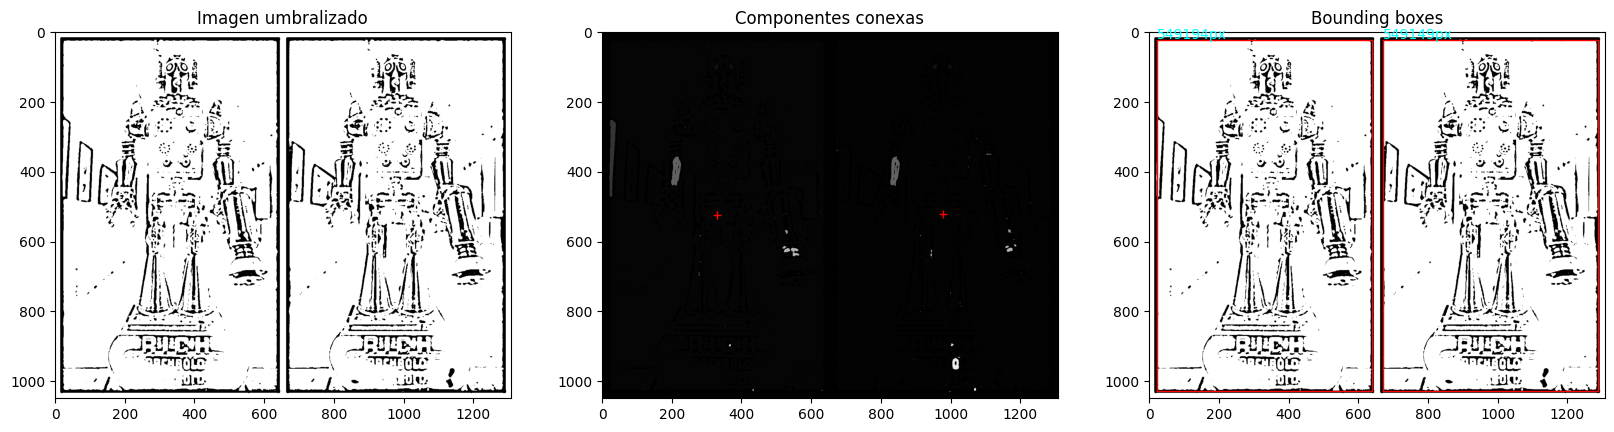

In [6]:
# Suavizado con filtro de mediana y umbralizado adaptativo para obtener imagen binarizada:
neighborhood_square = np.full((5,5), 1, dtype="uint8")
img_median = filters.rank.median(imgGray, neighborhood_square)
img_thr_adapt = filters.threshold_local(img_median, block_size=35, offset=10).astype("uint8")     # Aquí optamos por un umbral adaptativo, pues el umbral de Otsu no permitía separar el par estéreo en 2 componentes
bin_img = (img_median>img_thr_adapt).astype("uint8")                                              # Esta imagen binarizada es la que vamos a procesar para obtener las componenetes conexas


# Obtención de componentes conexas y selección de las asociadas al par estéreo:
ccs = cv2.connectedComponentsWithStats(bin_img, connectivity=4)     # Extracción de todas las componenetes conexas y sus características
areas = np.array([cc[-1] for cc in ccs[2]])                         # Almacenamos el área de cada componente conexa
select_ccs = np.logical_and(200000 < areas, areas < 1000000)      # Seleccionamos sólo aquellas componentes que nos interesan para extraer el par estéreo, filtrando por área y sabiendo que han de estar entre las de mayor área
print(f"Número de componentes = {ccs[0]} en total, {np.sum(select_ccs)} seleccionados por área.")


# hacemos un Plot de la imagen binarizada umbralizada y las dos componenetes conexas seleccionadas:
fig, axs = plt.subplots(1,3,figsize=(20,60))
axs[0].imshow(bin_img,cmap="gray")                                      # Imagen binarizada
axs[0].set_title("Imagen umbralizado")
axs[1].imshow(ccs[1],cmap="gray")                                       # Componentes conexas
axs[1].plot(ccs[3][select_ccs][:,0],ccs[3][select_ccs][:,1],"r+")       # Centros de las componentes
axs[1].set_title("Componentes conexas")
axs[2].imshow(bin_img,cmap="gray")
axs[2].set_title("Bounding boxes")
bounding_boxes = ccs[2][select_ccs][:,:-1]                              # Plot de las bounding boxes de las componentes seleccionadas sobre la imagen binarizada
for area, bb in zip(areas[select_ccs], bounding_boxes):
    axs[2].add_patch(Rectangle((bb[0], bb[1]), bb[2], bb[3], edgecolor='red', fill=False))
    axs[2].text(bb[0], bb[1]-2, f"{area}px", color='cyan')

True

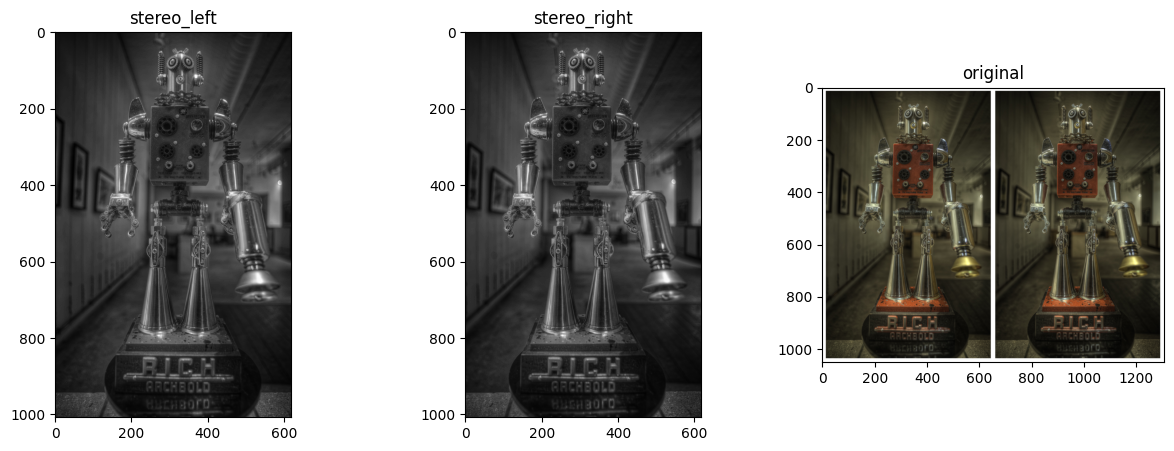

In [7]:
# Seleccionamos las bounding boxes asociadas a las dos componenetes que nos interesan y guardamos sus atributos de posiciónen una lista de 2 4-tuplas:
bounding_boxes = ccs[2][select_ccs][:, :-1]
bounding_boxes_coords = [(bb[0], bb[1], bb[2], bb[3]) for bb in bounding_boxes]


# Separamos los elementos de cada 4-tupla para diferenciar ambas componentes (left and right):
x_left , y_left , w_left , h_left = bounding_boxes_coords[1]
x_right , y_right , w_right , h_right = bounding_boxes_coords[0]


# Recortamos sobre la imagen en escala de gris (imgGray) las dos componentes asociadas al par estéreo:
x,y,w,h = x_left , y_left , w_left , h_left
roi_left = imgGray[y:y+h, x:x+w]

x,y,w,h = x_right , y_right , w_right , h_right
roi_right = imgGray[y:y+h, x:x+w]
roi_right = roi_right[1:,1:]  # Este recorte del tamaño de la imagen es necesario para que coincida con el de la otra imagen del par estéreo y poder computar el mapa de profundidad posteriormente.


# Mostramos en la notebook el exitoso resultado de la operación (hemos conseguido separar ambas componentes):
fig, axs = plt.subplots(1, 3, figsize = (15.,5.))
axs[0].imshow(roi_left, cmap="gray")
axs[0].set_title("stereo_left")
axs[1].imshow(roi_right, cmap="gray")
axs[1].set_title("stereo_right")
axs[2].imshow(img,cmap="gray")
axs[2].set_title("original")


# Recortamos de nuevo pero sobre la imagen original a color para guardar las imágenes:
x,y,w,h = x_left , y_left , w_left , h_left
roi_left_color = img[y:y+h, x:x+w]

x,y,w,h = x_right , y_right , w_right , h_right
roi_right_color = img[y:y+h, x:x+w]
roi_right_color = roi_right_color[1:,1:]


# Cambiamos el canal a BGR antes de guardar para que se guarden las imágenes en RGB:
roi_left_color = cv2.cvtColor(roi_left_color, cv2.COLOR_RGB2BGR)
roi_right_color = cv2.cvtColor(roi_right_color, cv2.COLOR_RGB2BGR)


# Guardamos el par estéreo a color en 2 imágenes diferentes:
cv2.imwrite ('Stereo_left_robot.jpg',roi_left_color)
cv2.imwrite ('Stereo_right_robot.jpg',roi_right_color)

Text(0.5, 1.0, 'Mapa de profundidad del robot')

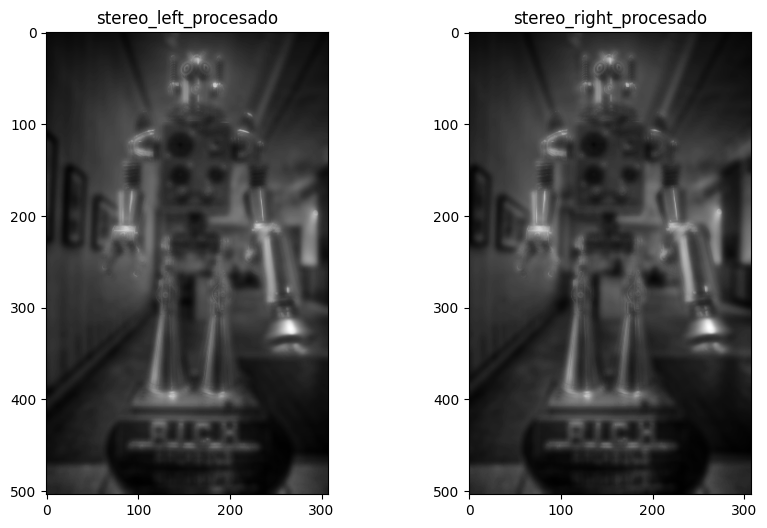

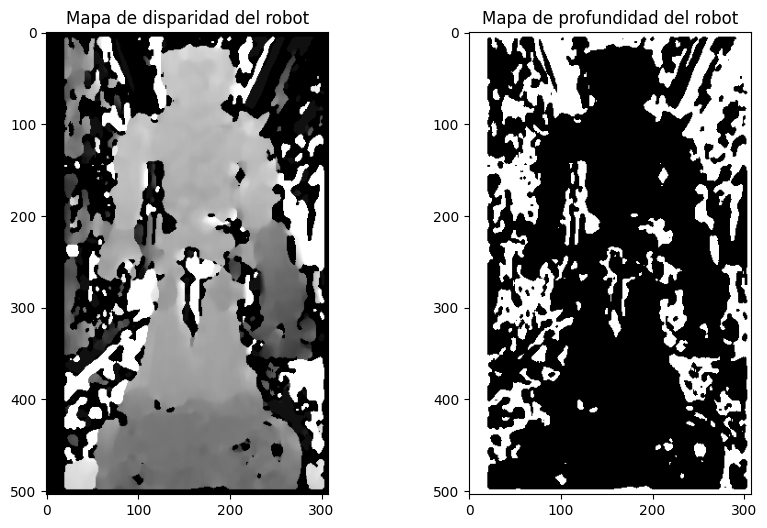

In [8]:
# Leemos las dos imágenes del par estéreo transformandolas a escala de gris con el tipo de dato adecuado
imgL = cv2.imread('Stereo_left_robot.jpg', cv2.IMREAD_GRAYSCALE).astype(np.uint8)
imgR = cv2.imread('Stereo_right_robot.jpg', cv2.IMREAD_GRAYSCALE).astype(np.uint8)


# Aplicamos un filtro bilateral que difumine la imagen preservando los bordes (cosa que ayudará a que el mapa de disparidad sea más preciso)
imgL = cv2.bilateralFilter(imgL, d=20, sigmaColor=75, sigmaSpace=75)
imgR = cv2.bilateralFilter(imgR, d=20, sigmaColor=75, sigmaSpace=75)

# Reescalamos las imágenes al 50% de las medidas originales. Esto mejora bastante la calidad del mapa de disparidad.
width = int(imgL.shape[1] * 0.5)   # 50% del ancho original
height = int(imgL.shape[0] * 0.5)  # 50% de la altura original
dim = (width, height)
imgL = cv2.resize(imgL, dim, interpolation=cv2.INTER_LINEAR)
imgR = cv2.resize(imgR, dim, interpolation=cv2.INTER_LINEAR)


# Mostramos el par estéreo preprocesado
fig, axs = plt.subplots(1, 2, figsize = (10.,6.))
axs[0].imshow(imgL, cmap="gray")
axs[0].set_title("stereo_left_procesado")
axs[1].imshow(imgR, cmap="gray")
axs[1].set_title("stereo_right_procesado")


# Creamos el mapa de disparidad:
stereo = cv2.StereoBM_create(numDisparities=16*1, blockSize=11)
disparity_map = stereo.compute(imgL,imgR)
disparity_map = cv2.medianBlur(disparity_map, 5)                                        # Filtro de mediana para el mapa de disparidad
disparity_map_normalized = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)  # Normalizamos el mapa de disparidad para que los contrastes no sean muy agresivos

# Creamos el mapa de profundidad a partir del mapa de disparidad (depth = f*B/D | f*B = 1)
depth_map = 1 / (disparity_map_normalized + 0.01)      # Evitamos división por cero


# Plot de los mapas:
fig, axs = plt.subplots(1, 2, figsize = (10.,6.))
axs[0].imshow(disparity_map_normalized,cmap='gray')
axs[0].set_title("Mapa de disparidad del robot")
axs[1].imshow(depth_map,cmap='gray')
axs[1].set_title("Mapa de profundidad del robot")

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio RC1B (0.75 pts)</strong></div>

* Calcular y mostrar en un gráfico de matplotlib el perfil de correlación de un parche de la
imagen izquierda con la correspondiente línea completa de la imagen derecha (tranparencia
30 del Tema 3).

* Computar la coordenada X correspondiente a la máxima correlación, dibujar
los parches aumentados de tamaño, e imprimir la disparidad (=desplazamiento relativo entre parches)
correspondiente.

La máxima correlación se alcanza en el parche número   80   de   201   con valor   0.6659715175628662   así que la disapridad entre los parches es de -20 pixeles
Además, la coordenada X relativa al parche de máxima correlación sobre la imagen de referencia es   X=288.   Aparece en color naranja.


Text(0, 0.5, 'correlation')

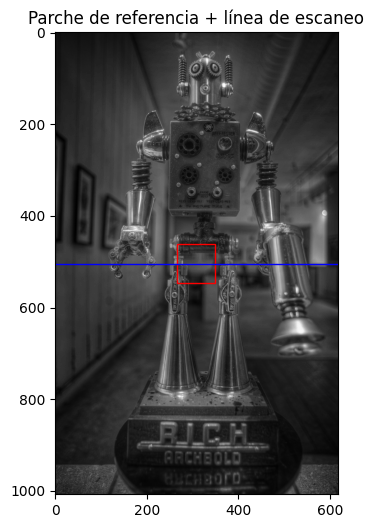

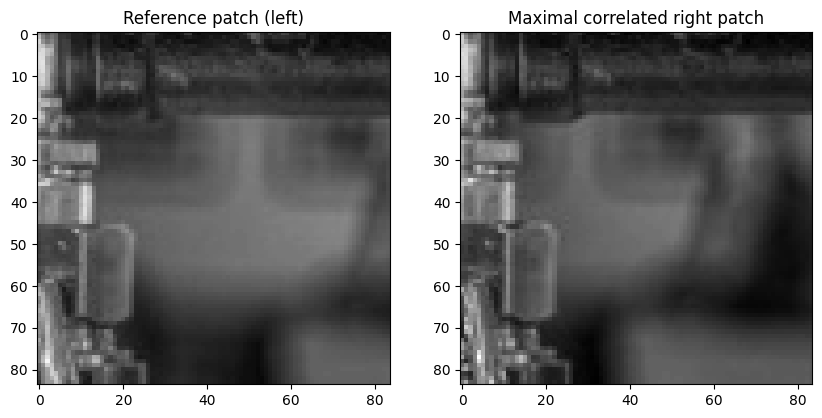

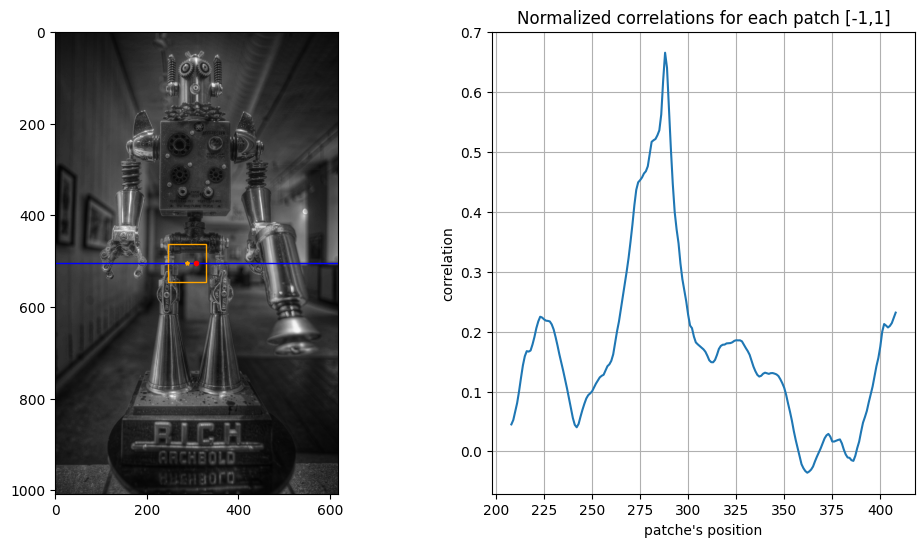

In [9]:
# Leemos en escala de gris el par estéreo del robot
img1 = cv2.imread('Stereo_left_robot.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Stereo_right_robot.jpg',cv2.IMREAD_GRAYSCALE)


# Definimos algunos parámetros (altura de la banda horizontal, tamaño del parche...)
Y = int(img1.shape[0]/2)       # Definimos la coordenada Y del centro del parche de referencia
X = int(img1.shape[1]/2)       # Definimos la coordenada X del centro del parche de referencia
w = 42                         # mitad de la base del parche
h = 42                         # mitad de la altura del parche
top_left = (X-w, Y-h)          # Esquina superior izquierda del parche (coordenadas)
bottom_right = (X+w, Y+h)      # Esquina inferior derecha del parche
search_window = 100            # Establecemos una ventana de búsqueda sobre la línea horizontal (simétrica resp. centro del parche de referencia)


# Mostrar la imagen en blanco y negro con matplotlib y el rectángulo rojo asociado al parche de referencia
plt.figure(figsize=(8, 6))
plt.title("Parche de referencia + línea de escaneo")
plt.imshow(img1, cmap='gray')  # Mostrar la imagen en escala de grises
rect = plt.Rectangle(top_left, bottom_right[0] - top_left[0], bottom_right[1] - top_left[1], linewidth=1, edgecolor='red', facecolor='none')    # Añadimos los bordes del parche de referencia en rojo
plt.gca().add_patch(rect)
plt.plot([0, img1.shape[1]-1], [Y, Y], color='blue', linewidth=1)           # Añadimos al plot la línea horizontal de escaneo en azul
ref_patch_left = img1[Y-h:Y+h , X-w:X+w]                                    # Recortamos el parche de referencia sobre la imagen izquierda del par estéreo


# Definimos un conjunto de parches (a lo largo de la línea azul) para realizar comparaciones que no sobrepasen la ventana de busqueda
right_patches_list = []
for i in range(-search_window,search_window+1):
    right_patches_list.append(img2[Y-h:Y+h , X+i-w:X+i+w])


# Comparamos la correlación de los parches de la banda con el parche izquierdo de referencia:
Max_corr=-1
Max_index=0
Loc=0
normalized_correlations_list = []

for i in range(len(right_patches_list)):
    result = cv2.matchTemplate(ref_patch_left, right_patches_list[i], cv2.TM_CCOEFF_NORMED)     # Matching respecto del parche de referencia
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    normalized_correlations_list.append(max_val)
    if  max_val > Max_corr:
        Max_corr = max_val
        Max_index = i
        Loc = max_loc


# Calclamos la disparidad respecto del parche de máxima correlación (derecha) y hacemos un print con algunos datos relevantes
disparidad = Max_index-search_window
print("La máxima correlación se alcanza en el parche número   "+str(Max_index)+"   de   "+str(2*search_window + 1)+"   con valor   "+str(Max_corr),"  así que la disapridad entre los parches es de " + str(disparidad) + " pixeles")
print("Además, la coordenada X relativa al parche de máxima correlación sobre la imagen de referencia es   X="+str(X+disparidad)+".   Aparece en color naranja.")
imshow_all(ref_patch_left, right_patches_list[Max_index] , titles=["Reference patch (left)","Maximal correlated right patch"])



# Mostrar la imagen en blanco y negro con matplotlib y el rectángulo rojo asociado al parche de referencia
fig, axs = plt.subplots(1, 2, figsize = (12,6))

top_left = ((X-w+disparidad, Y-h))

axs[0].imshow(img2, cmap='gray')  # Mostrar la imagen en escala de grises
rect = plt.Rectangle(top_left, 2*w, 2*h, linewidth=1, edgecolor='orange', facecolor='none')
axs[0].add_patch(rect)
axs[0].plot([0, img2.shape[1]-1], [Y, Y], color='blue', linewidth=1)    # Añadimos la línea azul de escaneo
axs[0].plot(X, Y, marker='o', color='red', markersize=3)                # Marcamos el centro del parche de referencia con un punto rojo (superpuesto sobre la imagen derecha del par estéreo)
axs[0].plot(X+disparidad, Y, marker='*', color='orange', markersize=3)

axs[1].plot([X + i - search_window for i in range(len(right_patches_list))] , normalized_correlations_list)
axs[1].grid(True)
axs[1].set_title('Normalized correlations for each patch [-1,1]')
axs[1].set_xlabel("patche's position")
axs[1].set_ylabel("correlation")

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio RC1C (0.35 pts)</strong></div>

* Hacer un gráfico interactivo para realizar una transformación geométrica de una imagen,
en la que se permitan modificar mediante sliders los parámetros:

    - de traslación (tx,ty ), escalado en ambos ejes (sx,sy)

    - rotación (α)
    - sesgo afín (a)
    - proyectividad horizontal y vertical (p1,p2)

* Utilizar para ello la parametrización propuesta en las notas de teoría sobre el plano proyectivo 2D (diapositiva 10).

In [ ]:
! pip install ipywidgets

In [10]:
from numpy.linalg import det, inv
from skimage import transform, img_as_ubyte, io

In [11]:
import cv2
import numpy as np
import math
from skimage import io, img_as_ubyte
import matplotlib.pyplot as plt
import ipywidgets as widgets

def transform_plot_save(image, alpha, tx, ty, sx, sy, a, px, py):

    rows, cols = image.shape[:-1]
    sx_ratio = 2  # Para dimensionar la ventana gráfica de forma proporcional al tamaño de la imagen en cada eje
    sy_ratio = 2  # Para dimensionar la ventana gráfica de forma proporcional al tamaño de la imagen en cada eje

    # Definimos la matriz de traslación del centro de la imagen
    Q = np.array([[1, 0, -cols//2],
                  [0, 1, -rows//2],
                  [0, 0, 1]])

    # Definimos la matriz de la transformación euclídea
    S = np.array([[sx * math.cos(math.radians(alpha)), -sx * math.sin(math.radians(alpha)), tx],
                  [sy * math.sin(math.radians(alpha)), sy * math.cos(math.radians(alpha)), ty],
                  [0, 0, 1.0]])

    # Definimos la matriz de la transformación Afin
    A = np.array([[1, a, 0],
                  [0, 1, 0],
                  [0, 0, 1]])

    # Definimos la matriz de la transformación proyectiva
    P = np.array([[1, 0, 0],
                  [0, 1, 0],
                  [px, py, 1]])

    # Definimos la matriz de traslación del centro de la imagen
    K = np.array([[1, 0, (sx_ratio*cols)//2],
                [0, 1, (sy_ratio*rows)//2],
                [0, 0, 1]])

    # Componemos las transformaciones (multiplicamos en el orden correcto sus matrices asociadas)
    M = K @ S @ A @ P @ Q

    # Aplicamos la composición de transformaciones a la imagen
    transformed_image = cv2.warpPerspective(image, M, dsize = (sx_ratio * cols, sy_ratio * rows))

    # Reformatamos de la imagen para poder guardarla con el comando io.imsave()
    transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())
    transformed_image_8bit = cv2.cvtColor(img_as_ubyte(transformed_image), cv2.COLOR_BGR2RGB)

    # Mostrar la imagen
    plt.imshow(transformed_image_8bit)
    plt.axis('off')
    plt.show()

    # Guardar la imagen
    io.imsave('Transformed_pato.png', transformed_image_8bit)

# Cargar la imagen
image = cv2.imread('ComputerVisionFiles/pato.jpg')
image = cv2.resize(image, (image.shape[1] // 4, image.shape[0] // 4))


# Crear sliders interactivos usando interact
widgets.interact(transform_plot_save,
                 image=widgets.fixed(image),
                 alpha=widgets.FloatSlider(value=0, min=0, max=360, step=1, description='Angle:'),
                 tx=widgets.FloatSlider(value=0, min=-image.shape[1]//2, max=image.shape[1]//2, step=1, description='Tx:'),
                 ty=widgets.FloatSlider(value=0, min=-image.shape[0]//2, max=image.shape[0]//2, step=1, description='Ty:'),
                 sx=widgets.FloatSlider(value=1, min=0.1, max=2, step=0.1, description='s_x:'),
                 sy=widgets.FloatSlider(value=1, min=0.1, max=2, step=0.1, description='s_y:'),
                 a=widgets.FloatSlider(value=0, min=-1, max=1, step=0.01, description='a:'),
                 px=widgets.FloatSlider(value=0, min=-0.01, max=0.01, step=0.001, description='p1:'),
                 py=widgets.FloatSlider(value=0, min=-0.01, max=0.01, step=0.001, description='p2:'))


interactive(children=(FloatSlider(value=0.0, description='Angle:', max=360.0, step=1.0), FloatSlider(value=0.0…

<function __main__.transform_plot_save(image, alpha, tx, ty, sx, sy, a, px, py)>

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio OP1A (0.2 pts)</strong></div>

Hacer el gráfico del ejercicio RC1B interactivo, de forma que el usuario pueda mover tanto la línea de
referencia como la coordenada X del parche de referencia.

In [12]:
import ipywidgets as widgets
from IPython.display import display, clear_output

### Para ejecución en Colab:

In [13]:
def ref_patch_corr_window_colab(imgL_route, imgR_route, w=42, h=42, search_window=100):
    # Leemos en escala de gris el par estéreo del robot
    imgColor = cv2.imread(imgL_route)                      # Imagen a color
    imgColorR = cv2.imread(imgR_route)
    img1 = cv2.imread(imgL_route, cv2.IMREAD_GRAYSCALE)    # Imagen izquierda en B&N
    img2 = cv2.imread(imgR_route, cv2.IMREAD_GRAYSCALE)    # Imagen derecha en B&N

    # Escalamos si las dimensiones son mayores a 2000 píxeles de ancho
    if img1.shape[1] > 2000:
        s1, s2 = int(img1.shape[1] * 0.25), int(img1.shape[0] * 0.25)
        dim = (s1, s2)
        img1 = cv2.resize(img1, dim, interpolation=cv2.INTER_LINEAR)
        img2 = cv2.resize(img2, dim, interpolation=cv2.INTER_LINEAR)
        imgColor = cv2.resize(imgColor, dim, interpolation=cv2.INTER_LINEAR)
        imgColorR = cv2.resize(imgColorR, dim, interpolation=cv2.INTER_LINEAR)

    # Parámetros iniciales
    Y = int(img1.shape[0] / 2)         # Mitad del alto de la imagen
    X = int(img1.shape[1] / 2)         # Mitad del ancho de la imagen
    top_left = (X - w, Y - h)
    bottom_right = (X + w, Y + h)

    # Configuración de los sliders usando ipywidgets
    ref_patch_X_slider = widgets.IntSlider(value=X - w, min=w + search_window, max=img1.shape[1] - w - search_window - 1, description='Ref Patch X')
    ref_patch_Y_slider = widgets.IntSlider(value=Y - h, min=h, max=img1.shape[0] - h - 1, description='Ref Patch Y')
    line_Y_slider = widgets.IntSlider(value=Y - h, min=0, max=img1.shape[0] - 2*h - 1, description='Line Y')

    # Botón de reset
    reset_button = widgets.Button(description="Reset Sliders")

    # Función de actualización de la visualización
    def update_display(ref_patch_X, ref_patch_Y, line_Y):
        # Actualización de coordenadas de parche y línea
        patch_X_coord = ref_patch_X + w
        patch_Y_coord = ref_patch_Y + h
        line_Y_coord = line_Y + h

        # Mostrar rectángulo y línea en la imagen original
        new_image = imgColor.copy()
        cv2.rectangle(new_image, (patch_X_coord - w, patch_Y_coord - h), (patch_X_coord + w, patch_Y_coord + h), color=(0, 0, 255), thickness=1)
        cv2.line(new_image, (0, line_Y_coord), (img1.shape[1], line_Y_coord), color=(255, 0, 0), thickness=2)

        # Definir parche de referencia
        ref_patch_left = img1[patch_Y_coord - h:patch_Y_coord + h, patch_X_coord - w:patch_X_coord + w]

        # Comparar parches en la imagen derecha
        right_patches_list = [img2[line_Y_coord - h:line_Y_coord + h, patch_X_coord + i - w:patch_X_coord + i + w] for i in range(-search_window, search_window + 1)]
        normalized_correlations_list = []
        Max_corr, Max_index, Loc = -1, 0, 0

        # Correlación de parches
        for i, right_patch in enumerate(right_patches_list):
            result = cv2.matchTemplate(ref_patch_left, right_patch, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, max_loc = cv2.minMaxLoc(result)
            normalized_correlations_list.append(max_val)
            if max_val > Max_corr:
                Max_corr, Max_index, Loc = max_val, i, max_loc

        # Disparidad calculada
        disparidad = Max_index - search_window

        # Visualización de resultados
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Imagen derecha con parche máximo correlacionado (NARANJA) y parche de referencia (ROJO)
        top_left_max_corr = (patch_X_coord + disparidad - w, line_Y_coord - h)
        top_left = (ref_patch_X,ref_patch_Y)
        rect_max = plt.Rectangle(top_left_max_corr, 2 * w, 2 * h, linewidth=1, edgecolor='orange', facecolor='none')
        rect_ref = plt.Rectangle(top_left, 2 * w, 2 * h, linewidth=1, edgecolor='red', facecolor='none')
        axs[0].imshow(cv2.cvtColor(imgColorR, cv2.COLOR_BGR2RGB))
        axs[0].add_patch(rect_max)
        axs[0].add_patch(rect_ref)
        axs[0].set_title("Parche de máxima correlación y disparidad resp. referencia")
        axs[0].plot([0, imgColor.shape[1] - 1], [line_Y_coord, line_Y_coord], color='blue', linewidth=1.5)
        axs[0].plot(patch_X_coord, patch_Y_coord, marker='o', color='red', markersize=3)
        axs[0].plot(patch_X_coord + disparidad, line_Y_coord, marker='*', color='orange', markersize=3)

        # Correlaciones normalizadas
        axs[1].plot([patch_X_coord + i - search_window for i in range(len(right_patches_list))], normalized_correlations_list)
        axs[1].grid(True)
        axs[1].set_title('Normalized correlations for each patch [-1,1]')
        axs[1].set_xlabel("Patch's position on the right image")
        axs[1].set_ylabel("Correlation")

        imshow_all(ref_patch_left, right_patches_list[Max_index] , titles=["Reference patch (left)","Maximal correlated patch (right)"])

        # Mostrar figuras actualizadas
        clear_output(wait=True)
        plt.show()

    # Función de reset de sliders
    def reset_sliders(b):
        ref_patch_X_slider.value = X - w
        ref_patch_Y_slider.value = Y - h
        line_Y_slider.value = Y - h

    # Conectar botón de reset con la función de reset
    reset_button.on_click(reset_sliders)

    # Interactividad con sliders
    ui = widgets.VBox([ref_patch_X_slider, ref_patch_Y_slider, line_Y_slider,reset_button])
    out = widgets.interactive_output(update_display, {'ref_patch_X': ref_patch_X_slider, 'ref_patch_Y': ref_patch_Y_slider, 'line_Y': line_Y_slider})

    display(ui, out)

In [14]:
ref_patch_corr_window_colab('Stereo_left_robot.jpg','Stereo_right_robot.jpg')

Output()

### Para ejecución SOLO en local o corrección en más detalle

Text(0.5, 1.0, 'Parche de referencia aumentado (escala de gris)')

<Figure size 800x800 with 0 Axes>

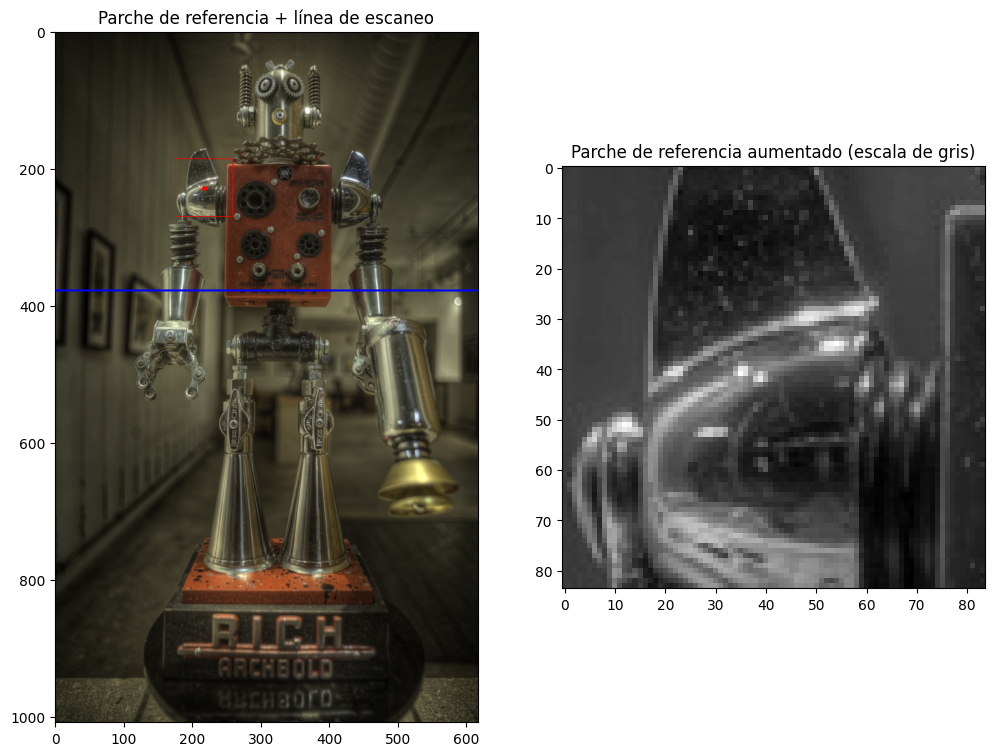

In [ ]:
# Leemos en escala de gris el par estéreo del robot
imgColor = cv2.imread('Stereo_left_robot.jpg')                      # Leemos también a color original para usarla en algunos plots
img1 = cv2.imread('Stereo_left_robot.jpg',cv2.IMREAD_GRAYSCALE)     # Leemos la parte izquierda del par estéreo en B&N
img2 = cv2.imread('Stereo_right_robot.jpg',cv2.IMREAD_GRAYSCALE)    # Leemos la parte derecha del par estéreo en B&N

# Definimos algunos parámetros
Y = int(img1.shape[0]/2)           # Aproximación entera de la medida del alto/2 de las imagenes del par estéreo (píxeles)
X = int(img1.shape[1]/2)           # Aproximación entera de la medida del ancho/2 de las imagenes del par estéreo (píxeles)
w = 42                             # Establecemos la medida del ancho del rectángulo que modela el parche de referencia (píxeles)
h = 42                             # Establecemos la medida del alto del rectángulo que modela el parche de referencia (píxeles)

top_left = (X-w, Y-h)           # Guardamos las coordenadas de la esquina superior izquierda del parche de referencia POR DEFECTO que definiremos para la ventna grafica con sliders
bottom_right = (X+w, Y+h)       # ... esquina inferior derecha ...
search_window = 100             # Establecemos un rango de búsqueda (píxeles) en el que realizar las comparaciones con el parche de referencia, sobre la línea horizontal azul  --->  (-100,100)


# Función que no hace nada (para inicializar los sliders)
def nothing(x):
    pass


# Inicializamos de forma vacía las variables que vamos a usar para programar el código que fabrica los sliders
line_Y = 0
patch_X_coord = 0
patch_Y_coord = 0


# Creamos una nueva ventana para los sliders y la imagen
windowName = "Elegir parche de referencia y línea de escaneo   --->   [ presione 'Q' para guardar y salir   |   presione 'R' para restablecer valores ]"
cv2.namedWindow(windowName,cv2.WINDOW_FULLSCREEN)

# Creamos los sliders ---> (nombre del slider en la nueva ventana, especificar la ventana, valor inicial del slider por defecto, valor máximo del slider,...)
cv2.createTrackbar('ref_patch_X',windowName,X-w-search_window,img1.shape[1]-2*w-1-2*search_window,nothing)      # Slider asociado a la corodenada X del parche de referencia
cv2.createTrackbar('ref_patch_Y',windowName,Y-h,img1.shape[0]-2*h-1,nothing)                                    # Slider asociado a la corodenada Y del parche de referencia
cv2.createTrackbar('line_Y',windowName,Y-h,img1.shape[0],nothing)                                               # Slider asociado a la altura de la línea horizontal de escaneo

    # los límites de valores para lso sliders se han escogido teniendo en cuenta que lo que queremos extraer es las coordenadas asociadas al centro del parche de referencia (como rectángulo)
    # y también, que los slider solo permiten valores enteros no-negativos y que el parche de referencia no peude salirse del dominiode píxeles marcado por la imagen sobre la que operamos
    # En esencia: Recortamos por derecha e izquierda y por arriba y abajo una cantidad, respectivamente, de w y h


# Creamos la figura para el próximo plot fuera del bucle while
plt.figure(figsize=(8, 8))


while True:
    # Obtenemos los valores actuales de los sliders (También aquí se manifiesta el recorte de las coordenadas de los sliders con +h y +w para que todo cuadre).
    line_Y = cv2.getTrackbarPos('line_Y',windowName)+h
    patch_X_coord = cv2.getTrackbarPos('ref_patch_X',windowName)+w+search_window
    patch_Y_coord = cv2.getTrackbarPos('ref_patch_Y',windowName)+h


    # Mostrar, sobre la imagen de referencia en blanco y negro, el rectángulo rojo asociado al parche de referencia y la línea azul de escaneo
    new_image = imgColor.copy()
    cv2.rectangle(new_image,(patch_X_coord-w,patch_Y_coord-h),(patch_X_coord+w,patch_Y_coord+h),color=(0,0,255),thickness=1)
    cv2.line(new_image,(0,line_Y),(img1.shape[1],line_Y),color=(255,0,0),thickness=2)
    cv2.imshow(windowName, new_image)

    # Salir del bucle y guardar los valores si se presiona la tecla 'Q' o restablecer sliders a valores por defecto presionando la tecla 'R'
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('r'):  # Al presionar 'R', restablecer valores  --->  (nombre del slider , valor por defecto asociado)
        line_Y = cv2.setTrackbarPos('line_Y',windowName,Y-h)
        patch_X_coord = cv2.setTrackbarPos('ref_patch_X',windowName,X-w-search_window)
        patch_Y_coord = cv2.setTrackbarPos('ref_patch_Y',windowName,Y-h)


# Liberar recursos y cerrar las ventanas
cv2.destroyAllWindows()


# Definimos el parche de referencia usando las coordenadas seleccinoadas mediante los sliders
ref_patch_left = img1[patch_Y_coord-h:patch_Y_coord+h , patch_X_coord-w:patch_X_coord+w]

# Mostramos el resultado de la ventana gráfica tras cerrarse y el parche de referencia (en escala de gris) que obtenemos en consecuencia
fig, axs = plt.subplots(1, 2, figsize = (12,12))
axs[0].imshow(cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB))                # new_image ya lleva incorporada aquí el rectángulo y la línea horizontal (desde el bucle while)
axs[0].set_title("Parche de referencia + línea de escaneo")
axs[0].plot(patch_X_coord, patch_Y_coord, marker='o', color='red', markersize=2.5)
axs[1].imshow(ref_patch_left, cmap="gray")
axs[1].set_title("Parche de referencia aumentado (escala de gris)")

La máxima correlación se alcanza en el parche número   60   con valor   0.2399594485759735   así que la disapridad entre los parches es de  -40  pixeles
Además, la coordenada X relativa al parche de máxima correlación sobre la imagen de referencia es   X=177.   Aparece en color naranja.


Text(0, 0.5, 'Correlation')

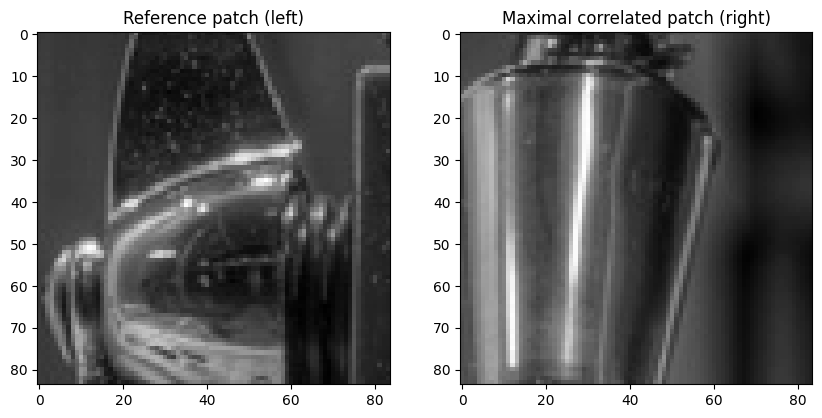

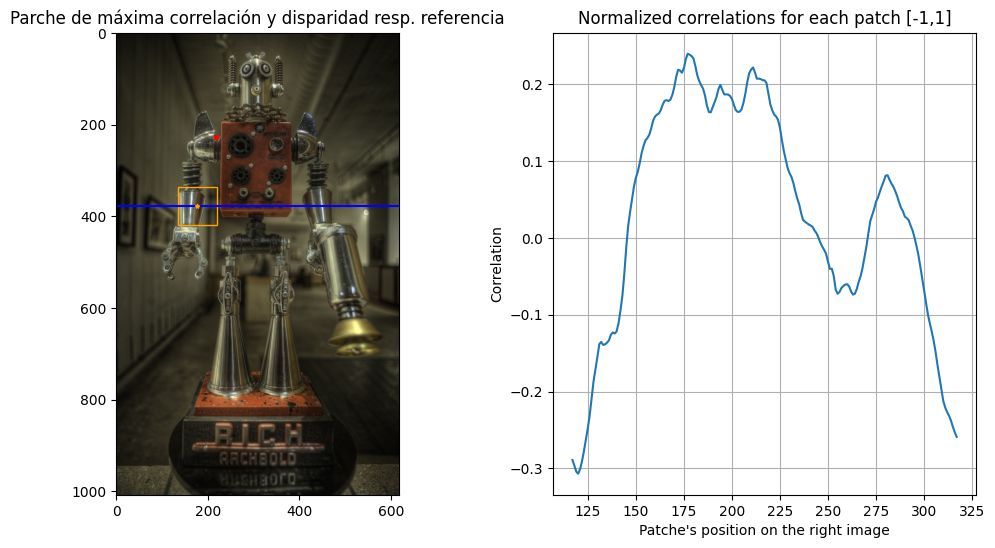

In [ ]:
# Definimos un conjunto de parches (a lo largo de la línea azul) para realizar comparaciones
right_patches_list = []
for i in range(-search_window,search_window+1):
    right_patches_list.append(img2[line_Y-h:line_Y+h , patch_X_coord+i-w:patch_X_coord+i+w])      # Los parches de comparación se están recortando sobre la parte derecha del par estéreo (img2)


# Comparamos la correlación de los parches a lo largo de la línea azul (y con restricción a la ventana de búsqueda) con el parche izquierdo de referencia
    # Inicializamos de forma vacía estas variables para emplearlas en el siguiente código
Max_corr=-1
Max_index=0
Loc=0
normalized_correlations_list = []

# Recorriendo la lista que contiene los parches para comparar de la imagen derecha, obtenemos la correlación normalizada de cada parche, almacenamos ese valor en una lista
# y guardamos tanto el máximo valor de las correlaciones normalizadas como el índice (sobre la lista de parches) donde se alcanza este máximo para después extraer ese parche en concreto.
for i in range(len(right_patches_list)):
    result = cv2.matchTemplate(ref_patch_left, right_patches_list[i], cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    normalized_correlations_list.append(max_val)
    if  max_val > Max_corr:
        Max_corr = max_val
        Max_index = i
        Loc = max_loc

disparidad = Max_index-search_window     # Aquí obtenemos al disparidad entre los dos parches como la diferencia horizontal (en pixeles) de sus centros al superponer el par estéreo
                                         # El signo de la disparidad modela la orientación del vector 2-D que une ambos centros partiendo del parche de referencia al superponer las imágenes

print("La máxima correlación se alcanza en el parche número   "+str(Max_index)+"   con valor   "+str(Max_corr),' ',"así que la disapridad entre los parches es de  " + str(disparidad) + "  pixeles")
print("Además, la coordenada X relativa al parche de máxima correlación sobre la imagen de referencia es   X="+str(patch_X_coord+disparidad)+".   Aparece en color naranja.")
imshow_all(ref_patch_left, right_patches_list[Max_index] , titles=["Reference patch (left)","Maximal correlated patch (right)"])


fig, axs = plt.subplots(1, 2, figsize = (12,6))
imgColor = cv2.imread('Stereo_right_robot.jpg')      # Leemos la imagen derecha a color


top_left = (patch_X_coord+disparidad-w,line_Y-h) # Tenemos en ceunta la disparidad para el plot del parche
base = 2*w
altura = 2*h
rect_max = plt.Rectangle(top_left, base, altura, linewidth=1, edgecolor='orange', facecolor='none')     # rectangulo asociado al parche de mayor correlacion sobre la imagen derecha


axs[0].imshow(cv2.cvtColor(imgColor,cv2.COLOR_BGR2RGB))
axs[0].add_patch(rect_max)
axs[0].set_title("Parche de máxima correlación y disparidad resp. referencia")
axs[0].plot([0, imgColor.shape[1]-1], [line_Y, line_Y], color='blue', linewidth=1.5)
axs[0].plot(patch_X_coord, patch_Y_coord, marker='o', color='red', markersize=3)            # (X coord centro parche de referencia , Y coord centro parche de referencia, en punto rojo)
axs[0].plot(patch_X_coord + disparidad, line_Y, marker='*', color='orange', markersize=3)   # (X coord centro mejor parche, Y coord centro mejor parche, en asterisco naranja)

axs[1].plot([patch_X_coord + i -search_window for i in range(len(right_patches_list))] , normalized_correlations_list)
axs[1].grid(True)
axs[1].set_title('Normalized correlations for each patch [-1,1]')
axs[1].set_xlabel("Patche's position on the right image")
axs[1].set_ylabel("Correlation")

#### ``Ejemplos adicionales``

In [ ]:
def ref_patch_corr_window(imgL_route,imgR_route,w=42,h=42,search_window=100):       # Esta función permite realizar todo el proceso de comparativa de parches mediante sliders con ventana de búsqueda

    # Leemos en escala de gris el par estéreo del robot
    imgColor = cv2.imread(imgL_route)                      # Leemos también a color original para usarla en algunos plots
    imgColorR = cv2.imread(imgR_route)
    img1 = cv2.imread(imgL_route,cv2.IMREAD_GRAYSCALE)     # Leemos la parte izquierda del par estéreo en B&N
    img2 = cv2.imread(imgR_route,cv2.IMREAD_GRAYSCALE)    # Leemos la parte derecha del par estéreo en B&N

    if img1.shape[1]>2000:
        s1 = int(img1.shape[1]*0.25)
        s2 = int(img1.shape[0]*0.25)
        dim = (s1, s2)
        img1 = cv2.resize(img1, dim, interpolation=cv2.INTER_LINEAR)
        img2 = cv2.resize(img2, dim, interpolation=cv2.INTER_LINEAR)
        imgColor = cv2.resize(imgColor, dim, interpolation=cv2.INTER_LINEAR)
        imgColorR = cv2.resize(imgColorR, dim, interpolation=cv2.INTER_LINEAR)



    # Definimos algunos parámetros
    Y = int(img1.shape[0]/2)           # Aproximación entera de la medida del alto/2 de las imagenes del par estéreo (píxeles)
    X = int(img1.shape[1]/2)           # Aproximación entera de la medida del ancho/2 de las imagenes del par estéreo (píxeles)

    top_left = (X-w, Y-h)           # Guardamos las coordenadas de la esquina superior izquierda del parche de referencia POR DEFECTO que definiremos para la ventna grafica con sliders
    bottom_right = (X+w, Y+h)       # ... esquina inferior derecha ...


    # Función que no hace nada (para inicializar los sliders)
    def nothing(x):
        pass


    # Inicializamos de forma vacía las variables que vamos a usar para programar el código que fabrica los sliders
    line_Y = 0
    patch_X_coord = 0
    patch_Y_coord = 0


    # Creamos una nueva ventana para los sliders y la imagen
    windowName = "Elegir parche de referencia y línea de escaneo   --->   [ presione 'Q' para guardar y salir   |   presione 'R' para restablecer valores ]"
    cv2.namedWindow(windowName)

    # Creamos los sliders ---> (nombre del slider en la nueva ventana, especificar la ventana, valor inicial del slider por defecto, valor máximo del slider,...)
    cv2.createTrackbar('ref_patch_X',windowName,X-w-search_window,img1.shape[1]-2*w-1-2*search_window,nothing)      # Slider asociado a la corodenada X del parche de referencia
    cv2.createTrackbar('ref_patch_Y',windowName,Y-h,img1.shape[0]-2*h-1,nothing)      # Slider asociado a la corodenada Y del parche de referencia
    cv2.createTrackbar('line_Y',windowName,Y-h,img1.shape[0],nothing)               # Slider asociado a la altura de la línea horizontal de escaneo

        # los límites de valores para lso sliders se han escogido teniendo en cuenta que lo que queremos extraer es las coordenadas asociadas al centro del parche de referencia (como rectángulo)
        # y también, que los slider solo permiten valores enteros no-negativos y que el parche de referencia no peude salirse del dominiode píxeles marcado por la imagen sobre la que operamos
        # En esencia: Recortamos por derecha e izquierda y por arriba y abajo una cantidad, respectivamente, de w y h


    # Creamos la figura para el próximo plot fuera del bucle while
    plt.figure(figsize=(8, 6))


    while True:
        # Obtenemos los valores actuales de los sliders (También aquí se manifiesta el recorte de las coordenadas de los sliders con +h y +w para que todo cuadre).
        line_Y = cv2.getTrackbarPos('line_Y',windowName)+h
        patch_X_coord = cv2.getTrackbarPos('ref_patch_X',windowName)+w+search_window
        patch_Y_coord = cv2.getTrackbarPos('ref_patch_Y',windowName)+h


        # Mostrar, sobre la imagen de referencia en blanco y negro, el rectángulo rojo asociado al parche de referencia y la línea azul de escaneo
        new_image = imgColor.copy()
        cv2.rectangle(new_image,(patch_X_coord-w,patch_Y_coord-h),(patch_X_coord+w,patch_Y_coord+h),color=(0,0,255),thickness=1)
        cv2.line(new_image,(0,line_Y),(img1.shape[1],line_Y),color=(255,0,0),thickness=2)
        cv2.imshow(windowName, new_image)

        # Salir del bucle y guardar los valores si se presiona la tecla 'Q' o restablecer sliders a valores por defecto presionando la tecla 'R'
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('r'):  # Al presionar 'R', restablecer valores  --->  (nombre del slider , valor por defecto asociado)
            line_Y = cv2.setTrackbarPos('line_Y',windowName,Y-h)
            patch_X_coord = cv2.setTrackbarPos('ref_patch_X',windowName,X-w-search_window)
            patch_Y_coord = cv2.setTrackbarPos('ref_patch_Y',windowName,Y-h)


    # Liberar recursos y cerrar las ventanas
    cv2.destroyAllWindows()


    # Definimos el parche de referencia usando las coordenadas seleccinoadas mediante los sliders
    ref_patch_left = img1[patch_Y_coord-h:patch_Y_coord+h , patch_X_coord-w:patch_X_coord+w]

    # Mostramos el resultado de la ventana gráfica tras cerrarse y el parche de referencia (en escala de gris) que obtenemos en consecuencia
    fig, axs = plt.subplots(1, 2, figsize = (12,12))
    axs[0].imshow(cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB))                # new_image ya lleva incorporada aquí el rectángulo y la línea horizontal (desde el bucle while)
    axs[0].set_title("Parche de referencia + línea de escaneo")
    axs[0].plot(patch_X_coord, patch_Y_coord, marker='o', color='red', markersize=2.5)
    axs[1].imshow(ref_patch_left, cmap="gray")
    axs[1].set_title("Parche de referencia aumentado (escala de gris)")



    # Definimos un conjunto de parches (a lo largo de la línea azul) para realizar comparaciones
    right_patches_list = []
    for i in range(-search_window,search_window+1):
        right_patches_list.append(img2[line_Y-h:line_Y+h , patch_X_coord+i-w:patch_X_coord+i+w])      # Los parches de comparación se están recortando sobre la parte derecha del par estéreo (img2)


    # Comparamos la correlación de los parches a lo largo de la línea azul (y con restricción a la ventana de búsqueda) con el parche izquierdo de referencia
        # Inicializamos de forma vacía estas variables para emplearlas en el siguiente código
    Max_corr=-1
    Max_index=0
    Loc=0
    normalized_correlations_list = []

    # Recorriendo la lista que contiene los parches para comparar de la imagen derecha, obtenemos la correlación normalizada de cada parche, almacenamos ese valor en una lista
    # y guardamos tanto el máximo valor de las correlaciones normalizadas como el índice (sobre la lista de parches) donde se alcanza este máximo para después extraer ese parche en concreto.
    for i in range(len(right_patches_list)):
        result = cv2.matchTemplate(ref_patch_left, right_patches_list[i], cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        normalized_correlations_list.append(max_val)
        if  max_val > Max_corr:
            Max_corr = max_val
            Max_index = i
            Loc = max_loc

    disparidad = Max_index-search_window     # Aquí obtenemos al disparidad entre los dos parches como la diferencia horizontal (en pixeles) de sus centros al superponer el par estéreo
                                             # El signo de la disparidad modela la orientación del vector 2-D que une ambos centros partiendo del parche de referencia al superponer las imágenes

    print("La máxima correlación se alcanza en el parche número   "+str(Max_index)+"   con valor   "+str(Max_corr),' ',"así que la disapridad entre los parches es de  " + str(disparidad) + "  pixeles")
    print("Además, la coordenada X relativa al parche de máxima correlación sobre la imagen de referencia es   X="+str(patch_X_coord+disparidad)+".   Aparece en color naranja.")
    imshow_all(ref_patch_left, right_patches_list[Max_index] , titles=["Reference patch (left)","Maximal correlated patch (right)"])


    fig, axs = plt.subplots(1, 2, figsize = (12,6))

    top_left = (patch_X_coord+disparidad-w,line_Y-h) # Tenemos en ceunta la disparidad para el plot del parche
    base = 2*w
    altura = 2*h
    rect_max = plt.Rectangle(top_left, base, altura, linewidth=1, edgecolor='orange', facecolor='none')     # rectangulo asociado al parche de mayor correlacion sobre la imagen derecha

    axs[0].imshow(cv2.cvtColor(imgColorR,cv2.COLOR_BGR2RGB))
    axs[0].add_patch(rect_max)
    axs[0].set_title("Parche de máxima correlación y disparidad resp. referencia")
    axs[0].plot([0, imgColor.shape[1]-1], [line_Y, line_Y], color='blue', linewidth=1.5)
    axs[0].plot(patch_X_coord, patch_Y_coord, marker='o', color='red', markersize=3)                   # (X coord centro parche de referencia , Y coord centro parche de referencia, en punto rojo)
    axs[0].plot(patch_X_coord + disparidad, line_Y, marker='*', color='orange', markersize=3)   # (X coord centro mejor parche, Y coord centro mejor parche, en asterisco naranja)

    axs[1].plot([patch_X_coord + i -search_window for i in range(len(right_patches_list))] , normalized_correlations_list)
    axs[1].grid(True)
    axs[1].set_title('Normalized correlations for each patch [-1,1]')
    axs[1].set_xlabel("Patche's position on the right image")
    axs[1].set_ylabel("Correlation")

In [ ]:
def ref_patch_corr_unlimited(imgL_route,imgR_route,w=42,h=42):  # Esta funcion realiza lo mismo que la anterior sin la limitación de tener una ventana de búsqueda preestablecida

    # Leemos en escala de gris el par estéreo del robot
    imgColor = cv2.imread(imgL_route)                      # Leemos también a color original para usarla en algunos plots
    imgColorR = cv2.imread(imgR_route)
    img1 = cv2.imread(imgL_route,cv2.IMREAD_GRAYSCALE)     # Leemos la parte izquierda del par estéreo en B&N
    img2 = cv2.imread(imgR_route,cv2.IMREAD_GRAYSCALE)    # Leemos la parte derecha del par estéreo en B&N

    if img1.shape[1]>2000:
        s1 = int(img1.shape[1]*0.25)
        s2 = int(img1.shape[0]*0.25)
        dim = (s1, s2)
        img1 = cv2.resize(img1, dim, interpolation=cv2.INTER_LINEAR)
        img2 = cv2.resize(img2, dim, interpolation=cv2.INTER_LINEAR)
        imgColor = cv2.resize(imgColor, dim, interpolation=cv2.INTER_LINEAR)
        imgColorR = cv2.resize(imgColorR, dim, interpolation=cv2.INTER_LINEAR)



    # Definimos algunos parámetros
    Y = int(img1.shape[0]/2)           # Aproximación entera de la medida del alto/2 de las imagenes del par estéreo (píxeles)
    X = int(img1.shape[1]/2)           # Aproximación entera de la medida del ancho/2 de las imagenes del par estéreo (píxeles)

    top_left = (X-w, Y-h)           # Guardamos las coordenadas de la esquina superior izquierda del parche de referencia POR DEFECTO que definiremos para la ventna grafica con sliders
    bottom_right = (X+w, Y+h)       # ... esquina inferior derecha ...


    # Función que no hace nada (para inicializar los sliders)
    def nothing(x):
        pass


    # Inicializamos de forma vacía las variables que vamos a usar para programar el código que fabrica los sliders
    line_Y = 0
    patch_X_coord = 0
    patch_Y_coord = 0


    # Creamos una nueva ventana para los sliders y la imagen
    windowName = "Elegir parche de referencia y línea de escaneo   --->   [ presione 'Q' para guardar y salir   |   presione 'R' para restablecer valores ]"
    cv2.namedWindow(windowName)

    # Creamos los sliders ---> (nombre del slider en la nueva ventana, especificar la ventana, valor inicial del slider por defecto, valor máximo del slider,...)
    cv2.createTrackbar('ref_patch_X',windowName,X-w-search_window,img1.shape[1]-2*w-1,nothing)      # Slider asociado a la corodenada X del parche de referencia
    cv2.createTrackbar('ref_patch_Y',windowName,Y-h,img1.shape[0]-2*h-1,nothing)      # Slider asociado a la corodenada Y del parche de referencia
    cv2.createTrackbar('line_Y',windowName,Y-h,img1.shape[0],nothing)               # Slider asociado a la altura de la línea horizontal de escaneo

        # los límites de valores para lso sliders se han escogido teniendo en cuenta que lo que queremos extraer es las coordenadas asociadas al centro del parche de referencia (como rectángulo)
        # y también, que los slider solo permiten valores enteros no-negativos y que el parche de referencia no peude salirse del dominiode píxeles marcado por la imagen sobre la que operamos
        # En esencia: Recortamos por derecha e izquierda y por arriba y abajo una cantidad, respectivamente, de w y h


    # Creamos la figura para el próximo plot fuera del bucle while
    plt.figure(figsize=(8, 6))


    while True:
        # Obtenemos los valores actuales de los sliders (También aquí se manifiesta el recorte de las coordenadas de los sliders con +h y +w para que todo cuadre).
        line_Y = cv2.getTrackbarPos('line_Y',windowName)+h
        patch_X_coord = cv2.getTrackbarPos('ref_patch_X',windowName)+w
        patch_Y_coord = cv2.getTrackbarPos('ref_patch_Y',windowName)+h


        # Mostrar, sobre la imagen de referencia en blanco y negro, el rectángulo rojo asociado al parche de referencia y la línea azul de escaneo
        new_image = imgColor.copy()
        cv2.rectangle(new_image,(patch_X_coord-w,patch_Y_coord-h),(patch_X_coord+w,patch_Y_coord+h),color=(0,0,255),thickness=1)
        cv2.line(new_image,(0,line_Y),(img1.shape[1],line_Y),color=(255,0,0),thickness=2)
        cv2.imshow(windowName, new_image)

        # Salir del bucle y guardar los valores si se presiona la tecla 'Q' o restablecer sliders a valores por defecto presionando la tecla 'R'
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('r'):  # Al presionar 'R', restablecer valores  --->  (nombre del slider , valor por defecto asociado)
            line_Y = cv2.setTrackbarPos('line_Y',windowName,Y-h)
            patch_X_coord = cv2.setTrackbarPos('ref_patch_X',windowName,X-w)
            patch_Y_coord = cv2.setTrackbarPos('ref_patch_Y',windowName,Y-h)


    # Liberar recursos y cerrar las ventanas
    cv2.destroyAllWindows()


    # Definimos el parche de referencia usando las coordenadas seleccinoadas mediante los sliders
    ref_patch_left = img1[patch_Y_coord-h:patch_Y_coord+h , patch_X_coord-w:patch_X_coord+w]

    # Mostramos el resultado de la ventana gráfica tras cerrarse y el parche de referencia (en escala de gris) que obtenemos en consecuencia
    fig, axs = plt.subplots(1, 2, figsize = (12,12))
    axs[0].imshow(cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB))                # new_image ya lleva incorporada aquí el rectángulo y la línea horizontal (desde el bucle while)
    axs[0].set_title("Parche de referencia + línea de escaneo")
    axs[0].plot(patch_X_coord, patch_Y_coord, marker='o', color='red', markersize=2.5)
    axs[1].imshow(ref_patch_left, cmap="gray")
    axs[1].set_title("Parche de referencia aumentado (escala de gris)")



    # Definimos un conjunto de parches (a lo largo de la línea azul) para realizar comparaciones
    right_patches_list = []
    X_left_diff = -patch_X_coord + w
    X_right_diff = img2.shape[1] - patch_X_coord - w
    l1 = [i for i in range(X_left_diff,0)]
    l2 = [j for j in range(0,X_right_diff+1)]

    range_list = l1+l2

    for i in range(len(range_list)):
        right_patches_list.append(img2[line_Y-h:line_Y+h , patch_X_coord+range_list[i]-w:patch_X_coord+range_list[i]+w])      # Los parches de comparación se están recortando sobre la parte derecha del par estéreo (img2)


    # Comparamos la correlación de los parches a lo largo de la línea azul (y con restricción a la ventana de búsqueda) con el parche izquierdo de referencia
        # Inicializamos de forma vacía estas variables para emplearlas en el siguiente código
    Max_corr=-1
    Max_index = 0
    Max_patch_position=0
    Loc=0
    normalized_correlations_list = []

    # Recorriendo la lista que contiene los parches para comparar de la imagen derecha, obtenemos la correlación normalizada de cada parche, almacenamos ese valor en una lista
    # y guardamos tanto el máximo valor de las correlaciones normalizadas como el índice (sobre la lista de parches) donde se alcanza este máximo para después extraer ese parche en concreto.
    for i in range(len(right_patches_list)):
        result = cv2.matchTemplate(ref_patch_left, right_patches_list[i], cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        normalized_correlations_list.append(max_val)
        if  max_val > Max_corr:
            Max_corr = max_val
            Max_patch_position = range_list[i]
            Loc = max_loc
            Max_index = i

    disparidad = Max_patch_position    # Aquí obtenemos al disparidad entre los dos parches como la diferencia horizontal (en pixeles) de sus centros al superponer el par estéreo
                                             # El signo de la disparidad modela la orientación del vector 2-D que une ambos centros partiendo del parche de referencia al superponer las imágenes

    print("La máxima correlación se alcanza en el parche número   "+str(Max_index)+"   con valor   "+str(Max_corr),' ',"así que la disapridad entre los parches es de  " + str(disparidad) + "  pixeles")
    print("Además, la coordenada X relativa al parche de máxima correlación sobre la imagen de referencia es   X="+str(patch_X_coord+disparidad)+".   Aparece en color naranja.")
    imshow_all(ref_patch_left, right_patches_list[Max_index] , titles=["Reference patch (left)","Maximal correlated patch (right)"])


    fig, axs = plt.subplots(1, 2, figsize = (12,6))

    top_left = (patch_X_coord+disparidad-w,line_Y-h) # Tenemos en ceunta la disparidad para el plot del parche
    base = 2*w
    altura = 2*h
    rect_max = plt.Rectangle(top_left, base, altura, linewidth=1, edgecolor='orange', facecolor='none')     # rectangulo asociado al parche de mayor correlacion sobre la imagen derecha

    axs[0].imshow(cv2.cvtColor(imgColorR,cv2.COLOR_BGR2RGB))
    axs[0].add_patch(rect_max)
    axs[0].set_title("Parche de máxima correlación y disparidad resp. referencia")
    axs[0].plot([0, imgColor.shape[1]-1], [line_Y, line_Y], color='blue', linewidth=1.5)
    axs[0].plot(patch_X_coord, patch_Y_coord, marker='o', color='red', markersize=3)                   # (X coord centro parche de referencia , Y coord centro parche de referencia, en punto rojo)
    axs[0].plot(patch_X_coord + disparidad, line_Y, marker='*', color='orange', markersize=3)   # (X coord centro mejor parche, Y coord centro mejor parche, en asterisco naranja)

    axs[1].plot([i for i in range(len(right_patches_list))] , normalized_correlations_list)
    axs[1].grid(True)
    axs[1].set_title('Normalized correlations for each patch [-1,1]')
    axs[1].set_xlabel("Patche's position on the right image")
    axs[1].set_ylabel("Correlation")

##### - Calendario

La máxima correlación se alcanza en el parche número   67   con valor   0.4080200791358948   así que la disapridad entre los parches es de  -183  pixeles
Además, la coordenada X relativa al parche de máxima correlación sobre la imagen de referencia es   X=170.   Aparece en color naranja.


<Figure size 800x600 with 0 Axes>

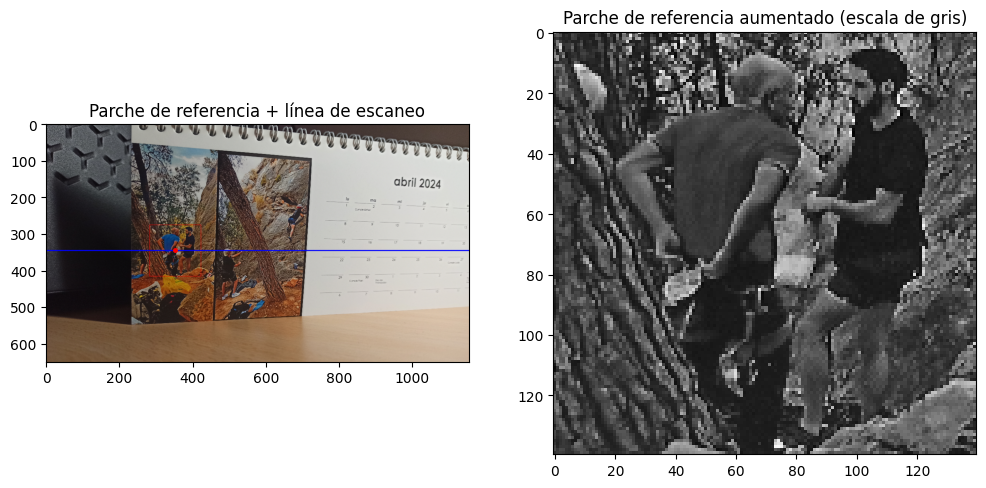

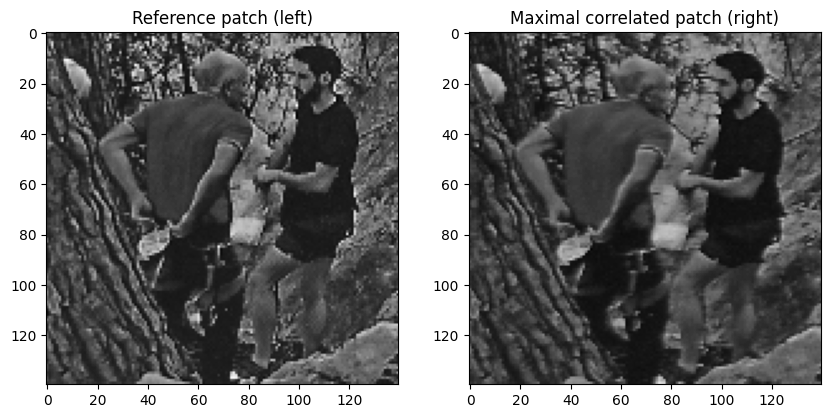

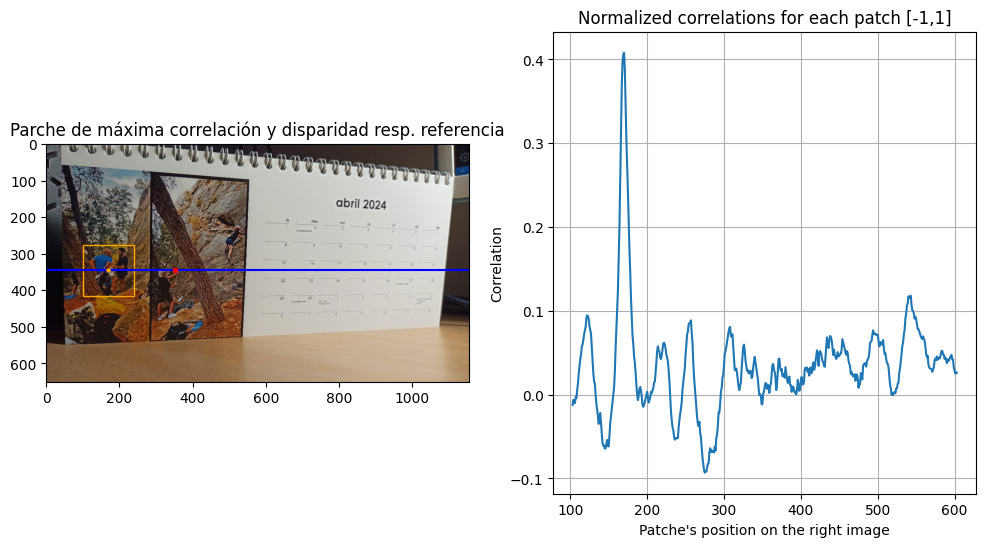

In [ ]:
imgL_route = "Calendario_left.jpg"
imgR_route = "Calendario_right.jpg"
w=70
h=70
search_window = 250

ref_patch_corr_window(imgL_route,imgR_route,w,h,search_window)

##### - Jarron

La máxima correlación se alcanza en el parche número   18   con valor   0.8445073366165161   así que la disapridad entre los parches es de  -215  pixeles
Además, la coordenada X relativa al parche de máxima correlación sobre la imagen de referencia es   X=63.   Aparece en color naranja.


<Figure size 800x600 with 0 Axes>

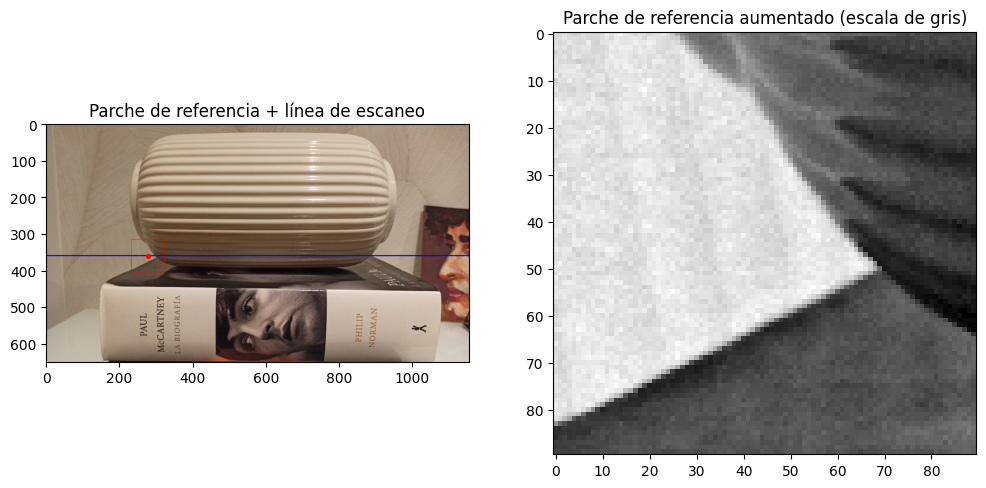

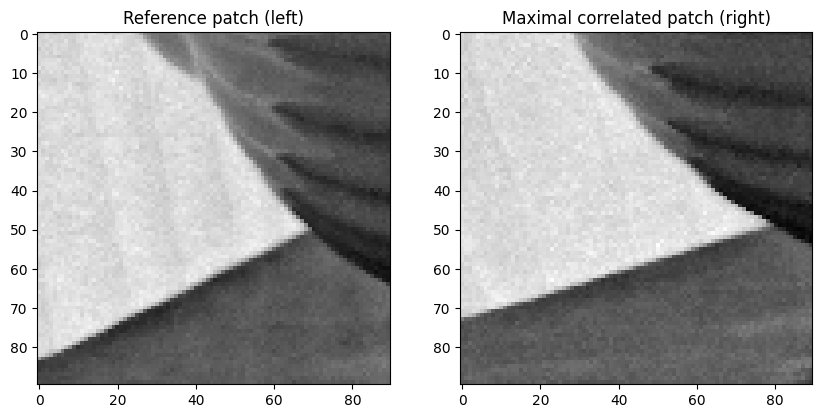

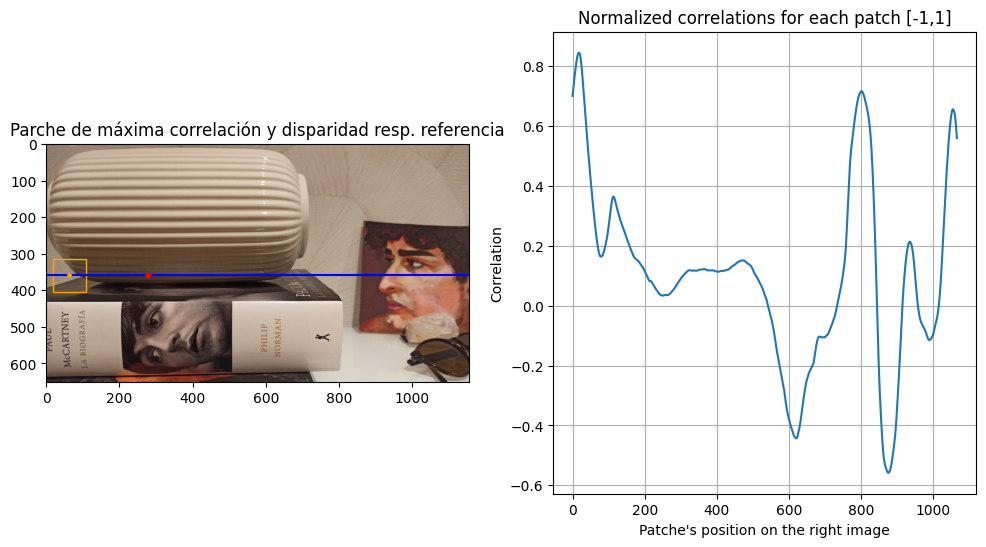

In [ ]:
imgL_route = "jarron_left.jpg"
imgR_route = "jarron_right.jpg"
w=45
h=45

ref_patch_corr_unlimited(imgL_route,imgR_route,w,h)

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio OP1E (0.2 pts)</strong></div>

Segmentar la componente conexa de la plantilla negra en el vídeo https://ditec.um.es/~pedroe/plantilla-L-15x15.avi del primer notebook

(es decir, obtener para cada frame una imagen binaria que contenga únicamente dicha componente)

In [16]:
!pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=75663068873196ff11d309a0ac668b4166f75d81ec4d5b6c8f258ac2163e3dab
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [19]:
#! wget -q https://univmurcia-my.sharepoint.com/:v:/g/personal/pedroe_um_es/EepaksW5vR1Cnn_xcmLfDiUBsFX_tk-1SPtD2YOCdyy5tA?download=1 -O plantilla-L-15x15.mp4
# LINK ALTERNATIVO:
! wget -q https://ditec.um.es/~pedroe/plantilla-L-15x15.mp4 -O plantilla-L-15x15.mp4

# ! ffmpeg -y -i inputvideo.avi -vcodec h264 -acodec mp2 outputvideo.mp4;

Para segmentar la componente conexa correspondiente a la plantilla negra en el vídeo, recorreremos cada frame del vídeo y lo procesaremos individualmente. Primero, convertiremos cada imagen a escala de grises y, utilizando el umbral de Otsu, la transformaremos en una imagen binaria. Con esta imagen binaria, ya podremos identificar las diferentes componentes conexas. Entre todas ellas, buscaremos la componente formada por la plantilla negra. Una vez encontrada, crearemos una nueva imagen con el fondo en blanco, donde solo aparecerá la componente deseada. Estas imágenes procesadas se utilizarán como los frames del nuevo vídeo.

In [20]:
# Abrimos vídeo y obtenemos un frame sólo, simplemente para saber el tamaño de
# cada frame (resolución):
videoreader = cv2.VideoCapture("plantilla-L-15x15.mp4")
(grabbed, frame) = videoreader.read()
videoshape = frame.shape
videoreader.release()

# Abrimos el vídeo
videoreader = cv2.VideoCapture("plantilla-L-15x15.mp4")

# Salida de vídeo para grabar cada frame procesado
videowriter = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*"mp4v"),
                              30, (videoshape[1], videoshape[0]), True)

# Recorremos cada frame, procesándolo para obtener la imagen binaria con una componente
i = 0
while True:
    (grabbed, img) = videoreader.read()

    if not grabbed:
        break

    else:
        # Convertimos la imagen a escala de grises
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Calculamos el umbral de Otsu
        thr_otsu = filters.threshold_otsu(img_gray)

        # Aplicamos el umbral de Otsu para obtener una imagen binaria
        binary_otsu = (img_gray<thr_otsu).astype("uint8")

        # Encontramos las componentes conexas en la imagen binaria
        ccs = cv2.connectedComponentsWithStats(binary_otsu, connectivity=4)

        # Seleccionamos solo la componente conexa de la plantilla negra,
        # buscándola por área
        areas = np.array([cc[-1] for cc in ccs[2]])
        select_ccs = np.logical_and(20000 < areas, areas < 70000)

        # En caso de que alguna componente del fondo también tenga un área entre
        # 20000 y 70000 nos quedamos con la más cercana al centro de la imagen,
        # que será la plantilla
        if sum(select_ccs) > 1:
            height, width = binary_otsu.shape
            center_x, center_y = width / 2, height / 2

            # Obtenemos los centroides de las componentes seleccionadas
            centroids = ccs[3]
            selected_centroids = centroids[select_ccs]

            # Calculamos las distancias de los centroides de cada componente al
            # centro de la imagen y nos quedamos con el de menor distancia
            distances = np.sqrt((selected_centroids[:, 0] - center_x) ** 2 + (selected_centroids[:, 1] - center_y) ** 2)
            min_index = np.argmin(distances)

            # Actualizar select_ccs para que solo la componente más cercana al
            # centro sea True
            true_indices = np.where(select_ccs)[0]
            best_index = true_indices[min_index]
            select_ccs = np.zeros_like(select_ccs, dtype=bool)
            select_ccs[best_index] = True

        # Crear una imagen en blanco del mismo tamaño que img
        output_image = np.ones_like(img) * 255

        # Pintar los píxeles de la componente seleccionada en negro
        for j in range(0, ccs[0]):
            if select_ccs[j]:  # Verificamos si la componente actual está en select_ccs
                output_image[ccs[1] == j] = [0,0,0]  # Pintar en negro

        # Escribimos la imagen binaria resultante en el vídeo de salida
        videowriter.write(output_image)

    # Siguiente frame:
    i += 1

videowriter.release()
videoreader.release()

Antes de mostrar el vídeo generado en el interfaz, hay que convertirlo al formato `.mp4`:

In [21]:
!ffmpeg -y -i output.avi -vcodec h264 -acodec mp2 output.mp4;

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Para reproducir el vídeo, usamos la función `play_video` sacada del Notebook 01.

In [22]:
from IPython.display import HTML
from base64 import b64encode

def play_video(videofilename):
    mp4 = open(videofilename,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
      <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

In [23]:
play_video('output.mp4')

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio OP1I (0.3 pts)</strong></div>

* Generar una imagen binaria con N círculos aleatorios con posibles solapamientos (al estilo de
la diapositiva 45), e intentar un conteo / segmentación de células utilizando la transformada de distancia.

Número de células detectadas: 34 de 50


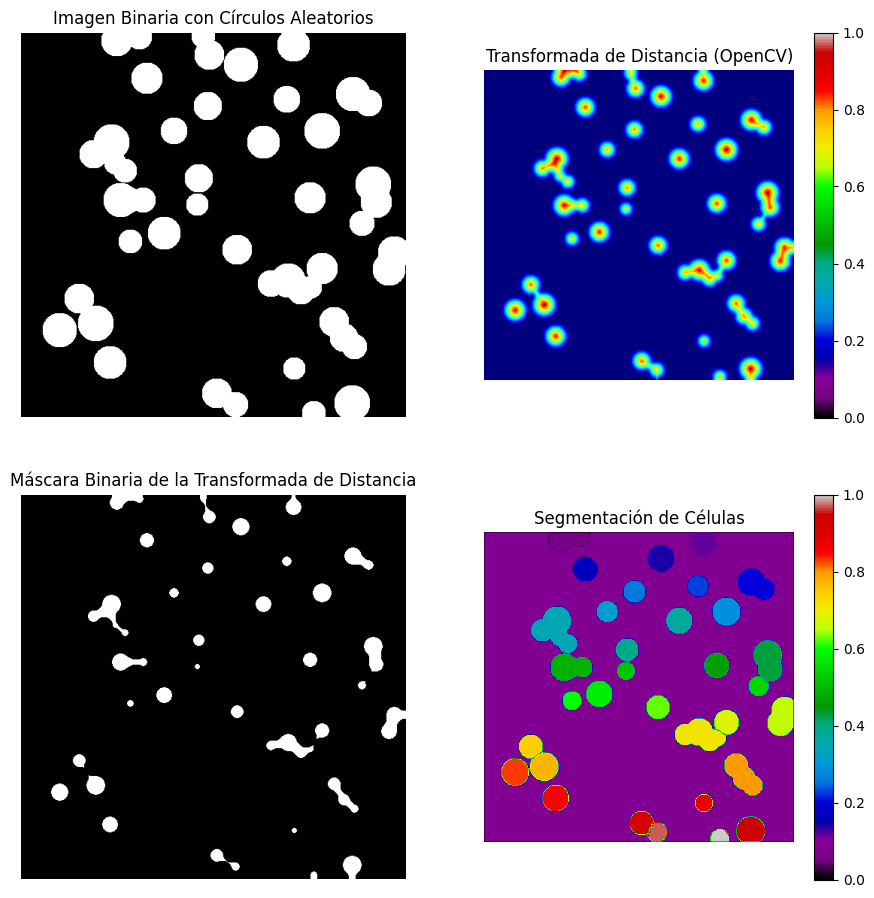

In [24]:
from skimage.draw import disk

# Parámetros
width, height = 512, 512  # Dimensiones de la imagen de fondo
N = 50                    # Número de círculos a imprimir
min_radius = 15           # Radio mínimo de los círculos
max_radius = 25           # Radio máximo de los círculos

# Crear una imagen binaria vacía del tamaño especificado (width,height)
image = np.zeros((height, width), dtype=np.uint8)

# Generar N círculos aleatorios de color blanco
for _ in range(N):
    center_x = np.random.randint(0, width)
    center_y = np.random.randint(0, height)
    radius = np.random.randint(min_radius, max_radius)
    rr, cc = disk((center_y, center_x), radius, shape=image.shape)
    image[rr, cc] = 255  # Usar 255 para blanco (círculo)

# Visualizamos la imagen binaria
fig, axs = plt.subplots(2, 2, figsize = (11,11))

axs[0,0].imshow(image, cmap='gray')
axs[0,0].set_title('Imagen Binaria con Círculos Aleatorios')
axs[0,0].axis('off')

# Calculamos la transformada de distancia ---> (imagen a la que se aplica,métrica elegida,tamaño de la máscara)
distance_transform = cv2.distanceTransform(image, cv2.DIST_L2, 5)

# Normalizamos la imagen de la transformada de distancia para la visualización
normalized_distance = cv2.normalize(distance_transform, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Visualizamos la transformada de distancia de la imagen
axs[0,1].imshow(normalized_distance, cmap='jet')
axs[0,1].set_title('Transformada de Distancia (OpenCV)')
axs[0,1].axis('off')
fig.colorbar(plt.cm.ScalarMappable(cmap='nipy_spectral'), ax=axs[0, 1], orientation='vertical')

# Segmentamos las células usando un umbralizado estándar
_, binary_mask = cv2.threshold(distance_transform, 0.5 * distance_transform.max(), 255, 0)
binary_mask = binary_mask.astype(np.uint8)

# Visualizamos la máscara binaria resultante
axs[1,0].imshow(binary_mask, cmap='gray')
axs[1,0].set_title('Máscara Binaria de la Transformada de Distancia')
axs[1,0].axis('off')

# Definimos los marcadores para la segmentación
markers = cv2.connectedComponents(binary_mask)[1]

# Segmentamos usando watershed
labels = cv2.watershed(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), markers)

# Visualizamos la segmentación de las componentes conexas
axs[1,1].imshow(labels, cmap='nipy_spectral')
axs[1,1].set_title('Segmentación de Células')
axs[1,1].axis('off')
fig.colorbar(plt.cm.ScalarMappable(cmap='nipy_spectral'), ax=axs[1, 1], orientation='vertical')

# Conteo de las células
num_cells = np.max(labels)
print(f'Número de células detectadas: {num_cells}'+' de '+str(N))